In [8]:
import string
import re
from os import listdir
from nltk.corpus import stopwords
from pickle import dump
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from IPython.display import Image

C:\Users\mgangwar\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [3]:
def clean_doc(doc):
    tokens = doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [4]:
def process_docs(directory, is_train):
    documents = list()
    for filename in listdir(directory):
        if is_train and filename.startswith('cv9'):
            continue
        if not is_train and not filename.startswith('cv9'):
            continue
        # create the full path of the file to open
        path = directory + '/' + filename
        doc = load_doc(path)
        tokens = clean_doc(doc)
        documents.append(tokens)
    return documents

In [5]:
def load_clean_dataset(is_train):
    neg = process_docs('txt_sentoken/neg', is_train)
    pos = process_docs('txt_sentoken/pos', is_train)
    docs = neg + pos
    labels = [0 for _ in range(len(neg))] + [1 for _ in range(len(pos))]
    return docs, labels

In [6]:
def save_dataset(dataset, filename):
    dump(dataset, open(filename, 'wb'))
    print('Saved: %s' % filename)

In [7]:
train_docs, ytrain = load_clean_dataset(True)
test_docs, ytest = load_clean_dataset(False)
# save training datasets
save_dataset([train_docs, ytrain], 'train.pkl')
save_dataset([test_docs, ytest], 'test.pkl')

Saved: train.pkl
Saved: test.pkl


The kernel size in the convolutional layer defines the number of words to consider as the convolution is passed across the input text document, providing a grouping parameter. A multi-channel convolutional neural network for document classification involves using multiple versions of the standard model with different sized kernels. This allows the document to be processed at different resolutions or different n-grams (groups of words) at a time, whilst the model learns how to best integrate these interpretations.

In [9]:
def load_dataset(filename):
    return load(open(filename,'rb'))

In [10]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [11]:
def max_length(lines):
    return max([len(s.split()) for s in lines])

In [12]:
def encode_text(tokenizer,lines,length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded,maxlen=length,padding='post')
    return padded

In [50]:
def define_model(length,vocab_size):
    #channel1
    inputs1 = Input(shape=(length,))
    embedding1 = Embedding(vocab_size,100)(inputs1)
    conv1 = Conv1D(filters=32,kernel_size=4,activation='relu')(embedding1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    #channel2
    inputs2 = Input(shape=(length,))
    embedding2 = Embedding(vocab_size,100)(inputs2)
    conv2 = Conv1D(filters=32,kernel_size=6,activation='relu')(embedding2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    #channel3
    inputs3 = Input(shape=(length,))
    embedding3 = Embedding(vocab_size,100)(inputs3)
    conv3 = Conv1D(filters=32,kernel_size=8,activation='relu')(embedding3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    
    merged = concatenate([flat1,flat2,flat3])
    dense1 = Dense(10, activation='relu')(merged)
    outputs = Dense(1, activation='sigmoid')(dense1)
    
    model = Model(inputs=[inputs1,inputs2,inputs3],outputs=outputs)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    plot_model(model, show_shapes=True, to_file='model2.png')
    return model

In [51]:
trainLines, trainLabels = load_dataset('train.pkl')
tokenizer = create_tokenizer(trainLines)

length = max_length(trainLines)
print('Max document length: %d' % length)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary size: %d' % vocab_size)

Max document length: 1380
Vocabulary size: 44277


In [52]:
trainX = encode_text(tokenizer, trainLines, length)
model = define_model(length,vocab_size)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 1380)         0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 1380)         0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 1380)         0                                            
__________________________________________________________________________________________________
embedding_22 (Embedding)        (None, 1380, 100)    4427700     input_22[0][0]                   
__________________________________________________________________________________________________
embedding_

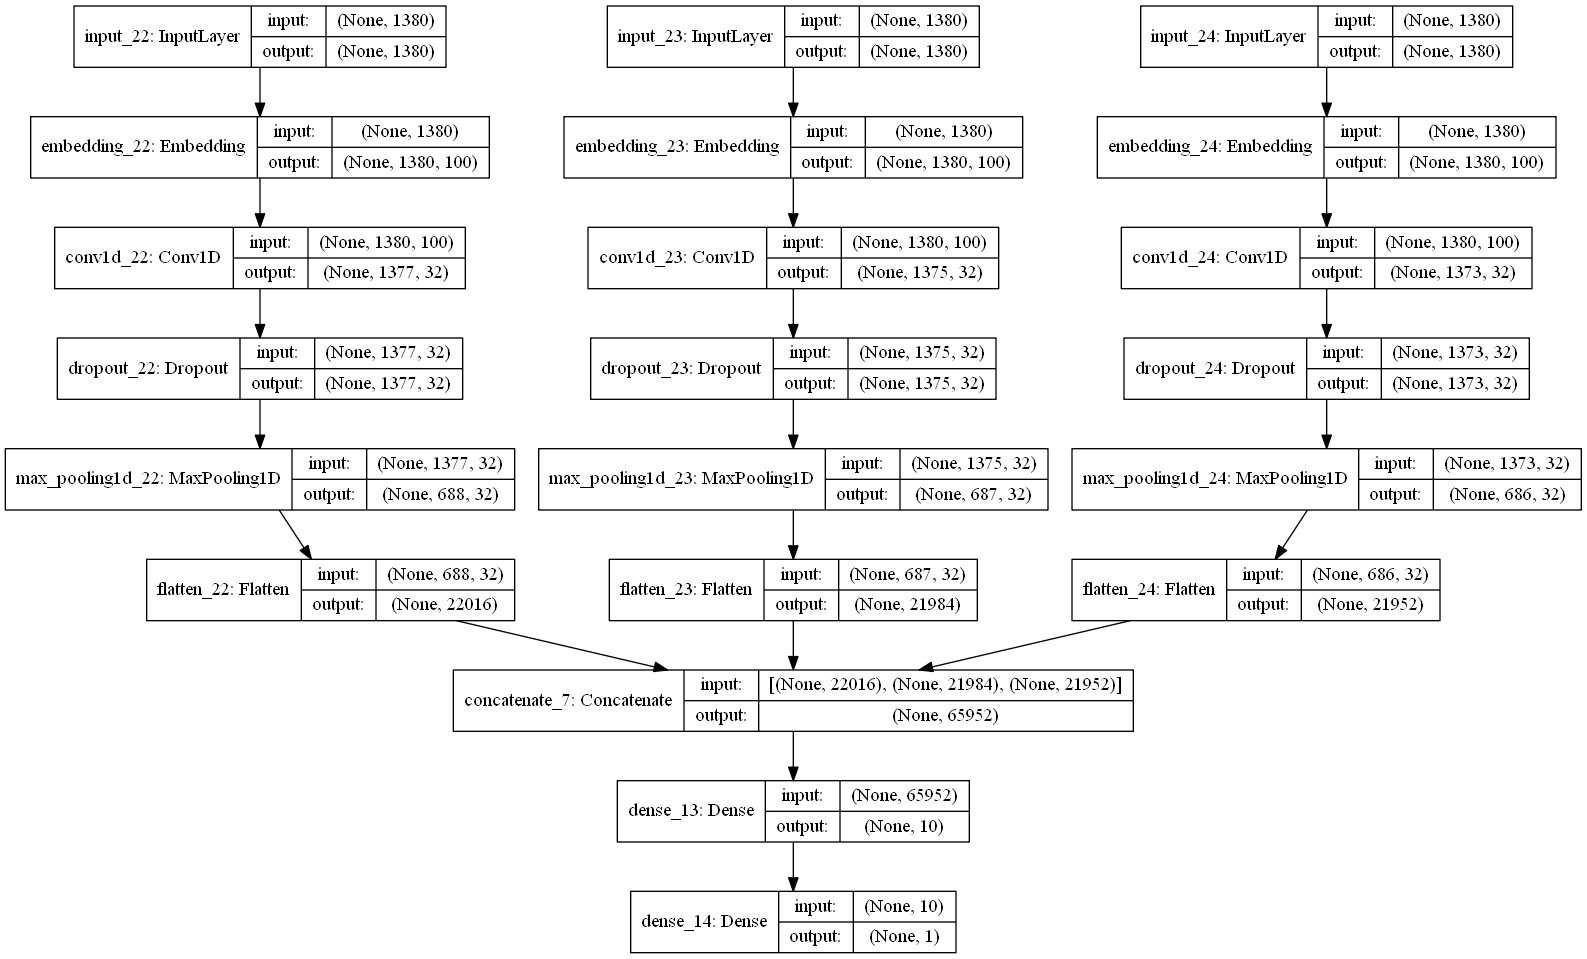

In [53]:
Image(filename='model2.png')

In [54]:
model.fit([trainX,trainX,trainX],array(trainLabels),epochs=7,batch_size=16)

Epoch 1/7
1800/1800 [==============================] - 56s 31ms/step - loss: 0.6945 - acc: 0.4956
Epoch 2/7
1800/1800 [==============================] - 54s 30ms/step - loss: 0.6878 - acc: 0.5444
Epoch 3/7
1800/1800 [==============================] - 54s 30ms/step - loss: 0.3847 - acc: 0.8139
Epoch 4/7
1800/1800 [==============================] - 54s 30ms/step - loss: 0.0202 - acc: 0.9978
Epoch 5/7
1800/1800 [==============================] - 54s 30ms/step - loss: 0.0036 - acc: 0.9994
Epoch 6/7
1800/1800 [==============================] - 55s 31ms/step - loss: 0.0015 - acc: 0.9994
Epoch 7/7
1800/1800 [==============================] - 54s 30ms/step - loss: 5.7025e-04 - acc: 1.0000


In [55]:
testLines, testLabels = load_dataset('test.pkl')
testX = encode_text(tokenizer,testLines,length)
print(trainX.shape, testX.shape)

(1800, 1380) (200, 1380)


In [56]:
_, acc = model.evaluate([trainX,trainX,trainX], array(trainLabels), verbose=0)
print('Train Accuracy: %.2f' % (acc*100))

_, acc = model.evaluate([testX,testX,testX], array(testLabels), verbose=0)
print('Test Accuracy: %.2f' % (acc*100))

Train Accuracy: 100.00
Test Accuracy: 86.00
